In [92]:
# Import required libraries
import pandas as pd
import numpy as np
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import matplotlib.pyplot as plt
import seaborn as sns
import decoupler as dc


/opt/homebrew/Caskroom/miniconda/base/envs/hrdclas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [33]:
# Load the RNA-seq data
rnaseq_df = pd.read_csv('data/tcga.brca.rnaseq.unstranded.fpkm.counts.matrix.txt', sep='\t', index_col=0)

# Load the HRD score data
hrd_df = pd.read_excel('data/tcga.hrdscore.xlsx')

# Load the BRCA status data
brca_df = pd.read_csv('data/toga.breast.brca.status.txt', sep='\t', index_col=0)
brca_df.index = brca_df.index.str.replace('.', '-')


In [34]:
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samples = set(rnaseq_df['Case ID'])
hrd_samples = set(hrd_df['sample'])
brca_samples = set(brca_df.index)

# Find the intersection of all sample IDs
common_samples = rnaseq_samples.intersection(hrd_samples).intersection(brca_samples)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samples))



Number of common samples: 864


In [35]:
# Drop samples that are not common in all three dataframes
rnaseq_df_common = rnaseq_df[rnaseq_df['Case ID'].isin(common_samples)]
hrd_df_common = hrd_df[hrd_df['sample'].isin(common_samples)]
brca_df_common = brca_df[brca_df.index.isin(common_samples)]

# Print the shapes of the new dataframes
print("rnaseq_df_common:", rnaseq_df_common.shape)
print("hrd_df_common:", hrd_df_common.shape)
print("brca_df_common:", brca_df_common.shape)

rnaseq_df_common: (929, 60663)
hrd_df_common: (864, 5)
brca_df_common: (864, 33)


In [36]:
rnaseq_df_common.head()

,Case ID,Sample ID,Sample Type,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
0,TCGA-E9-A1RH,TCGA-E9-A1RH-01A,Primary Tumor,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
1,TCGA-C8-A26W,TCGA-C8-A26W-01A,Primary Tumor,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
2,TCGA-E9-A1RH,TCGA-E9-A1RH-11A,Solid Tissue Normal,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
3,TCGA-AO-A0JJ,TCGA-AO-A0JJ-01A,Primary Tumor,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
4,TCGA-BH-A0HO,TCGA-BH-A0HO-01A,Primary Tumor,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599


In [37]:
#merge metadata

metadata = pd.merge(hrd_df_common, brca_df_common, left_on='sample', right_index=True)
metadata.set_index('sample', inplace=True)

print (metadata.shape)
print(metadata.columns)
metadata.head()

(864, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


,HRD,Telomeric AI,LST,HRD-sum,BRCA1_somatic_null,BRCA1_germ_bi_allelic,BRCA1_germ_mono_allelic,BRCA1_deletion,BRCA1_epigenetic_silencing,BRCA1_mRNA,...,H2.norm,H3.norm,H4.norm,event.BRCA1,event.BRCA2,event.RAD51C,event.PALB2,event.All Events,event.PAM50,event.TNBC
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-A1-A0SB,0,0,0,0,0,0,0,0,0,0,...,0.044837,0.635070,0.000000,0,0,0,0,0,NaN,0
TCGA-A1-A0SD,10,10,7,27,0,0,0,0,0,0,...,0.254169,0.703974,0.041857,0,0,0,0,0,LumA,0
TCGA-A1-A0SE,6,6,1,13,0,0,0,0,0,0,...,0.102998,0.740053,0.120368,0,0,0,0,0,LumA,0
TCGA-A1-A0SF,7,11,8,26,0,0,0,0,0,0,...,0.000000,0.395329,0.604671,0,0,0,0,0,LumA,0
TCGA-A1-A0SG,3,2,4,9,0,0,0,0,0,0,...,0.183277,0.776319,0.040404,0,0,0,0,0,LumA,0


In [38]:

# Start with the original dataframe
metadata_filtered = metadata.copy()

# Drop rows where event.BRCA1 is '1'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA1'] != '1']

# Drop rows where event.BRCA2 is 'Bi-allelic-undetermined'
metadata_filtered = metadata_filtered[metadata_filtered['event.BRCA2'] != 'Bi-allelic-undetermined']

# Drop rows where event.PALB2 is '2'
metadata_filtered = metadata_filtered[metadata_filtered['event.PALB2'] != '2']

print (metadata_filtered.shape)
print(metadata_filtered.columns)
metadata_filtered.head()

metadata = metadata_filtered
metadata['HRD_status'] = ['HRD' if x >= 42 else 'HR' for x in metadata['HRD-sum']]
metadata['HRD_status'].value_counts()

(857, 37)
Index(['HRD', 'Telomeric AI', 'LST', 'HRD-sum', 'BRCA1_somatic_null',
       'BRCA1_germ_bi_allelic', 'BRCA1_germ_mono_allelic', 'BRCA1_deletion',
       'BRCA1_epigenetic_silencing', 'BRCA1_mRNA', 'BRCA2_somatic_null',
       'BRCA2_germ_bi_allelic', 'BRCA2_germ_undetermined',
       'BRCA2_germ_mono_allelic', 'BRCA2_deletion', 'RAD51C_germ',
       'RAD51C_deletion', 'RAD51C_epigenetic_silencing', 'RAD51C_mRNA',
       'PALB2_somatic_null', 'PALB2_germ', 'TP53_somatic', 'H1', 'H2', 'H3',
       'H4', 'H1.norm', 'H2.norm', 'H3.norm', 'H4.norm', 'event.BRCA1',
       'event.BRCA2', 'event.RAD51C', 'event.PALB2', 'event.All Events',
       'event.PAM50', 'event.TNBC'],
      dtype='object')


HRD_status
HR     652
HRD    205
Name: count, dtype: int64

In [43]:
# drop rna samples not in metadata
#idenfity the common samples

# Extract sample IDs from each dataframe
rnaseq_samp = set(rnaseq_df['Case ID'])
metadata_samp = set(metadata.index)

# Find the intersection of all sample IDs
common_samp = rnaseq_samp.intersection(metadata_samp)

# Print the number of common samples
print("\nNumber of common samples:", len(common_samp))



Number of common samples: 857


In [45]:
# Drop samples that are not common between metadata and rnaseq data
rnaseq_df_filtered = rnaseq_df_common[rnaseq_df_common['Case ID'].isin(common_samp)]
rnaseq_df_filtered.shape

(921, 60663)

In [55]:
rnaseq_df_filtered.head()


,ENSG00000000003.15|TSPAN6|protein_coding,ENSG00000000005.6|TNMD|protein_coding,ENSG00000000419.13|DPM1|protein_coding,ENSG00000000457.14|SCYL3|protein_coding,ENSG00000000460.17|C1orf112|protein_coding,ENSG00000000938.13|FGR|protein_coding,ENSG00000000971.16|CFH|protein_coding,ENSG00000001036.14|FUCA2|protein_coding,ENSG00000001084.13|GCLC|protein_coding,ENSG00000001167.14|NFYA|protein_coding,...,ENSG00000288661.1|AL451106.1|protein_coding,ENSG00000288662.1|AC092910.4|lncRNA,ENSG00000288663.1|AC073611.1|lncRNA,ENSG00000288665.1|AC136977.1|lncRNA,ENSG00000288667.1|AC078856.1|lncRNA,ENSG00000288669.1|AC008763.4|protein_coding,ENSG00000288670.1|AL592295.6|lncRNA,ENSG00000288671.1|AC006486.3|protein_coding,ENSG00000288674.1|AL391628.1|protein_coding,ENSG00000288675.1|AP006621.6|protein_coding
Case ID,,,,,,,,,,,,,,,,,,,,,
TCGA-E9-A1RH,1.0276,0.0000,74.2709,1.3816,1.6749,1.4166,5.2410,8.4782,5.9064,19.4040,...,0.0,0.0000,0.0177,0.0,0.0000,0.0000,1.8073,0.0,0.0000,0.1285
TCGA-C8-A26W,13.2684,0.1250,37.9298,3.7360,3.1045,2.4799,7.4851,30.4546,4.3523,17.3752,...,0.0,0.0000,0.0847,0.0,0.0000,0.0036,3.4634,0.0,0.0074,0.3801
TCGA-E9-A1RH,12.8007,8.4777,21.6363,2.4554,0.5852,2.7533,27.4655,13.6652,6.0568,5.9571,...,0.0,0.2708,0.0456,0.0,0.2664,0.0041,5.8816,0.0,0.0372,0.1064
TCGA-AO-A0JJ,14.8681,2.2172,27.8838,4.3170,1.7847,3.7167,9.6630,16.7889,3.6701,9.3094,...,0.0,0.0000,0.0261,0.0,0.0000,0.0000,3.2723,0.0,0.0058,0.2546
TCGA-BH-A0HO,0.8430,0.0798,22.1105,3.9971,0.9805,2.4742,3.8185,12.5473,5.9260,10.1433,...,0.0,0.0000,0.0253,0.0,0.0000,0.0000,3.1233,0.0,0.0041,0.4599


In [56]:

rnaseq_df_filtered = rnaseq_df_filtered.set_index('Case ID').drop(['Sample ID', 'Sample Type'], axis=1)
rnaseq_df_filtered.head()

KeyError: "None of ['Case ID'] are in the columns"

In [59]:
rnaseq_df_filtered = rnaseq_df_filtered.round().astype(int)
rnaseq_df_filtered = rnaseq_df_filtered[~rnaseq_df_filtered.index.duplicated(keep='first')]

In [61]:
print(f"Shape of rnaseq_df_filtered: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata: {metadata.shape}")

Shape of rnaseq_df_filtered: (857, 60660)
Shape of metadata: (857, 38)


In [62]:
print("rnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])  # Print first 5 index values
print("\nmetadata index:")
print(metadata.index[:5])  # Print first 5 index values

# Check for any mismatches
mismatched = set(rnaseq_df_filtered.index) ^ set(metadata.index)
print(f"\nNumber of mismatched indices: {len(mismatched)}")
if len(mismatched) > 0:
    print("Sample of mismatched indices:")
    print(list(mismatched)[:5])  # Print up to 5 mismatched indices

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object', name='Case ID')

metadata index:
Index(['TCGA-A1-A0SB', 'TCGA-A1-A0SD', 'TCGA-A1-A0SE', 'TCGA-A1-A0SF',
       'TCGA-A1-A0SG'],
      dtype='object', name='sample')

Number of mismatched indices: 0


In [69]:
# Find common indices
common_indices = rnaseq_df_filtered.index.intersection(metadata.index)

# Filter both DataFrames to keep only common indices
rnaseq_df_filtered = rnaseq_df_filtered.loc[common_indices]
metadata = metadata.loc[common_indices]

# Verify the shapes and indices again
print(f"Shape of rnaseq_df_filtered after alignment: {rnaseq_df_filtered.shape}")
print(f"Shape of metadata after alignment: {metadata.shape}")

print("\nrnaseq_df_filtered index:")
print(rnaseq_df_filtered.index[:5])
print("\nmetadata index:")
print(metadata.index[:5])

Shape of rnaseq_df_filtered after alignment: (857, 60660)
Shape of metadata after alignment: (857, 38)

rnaseq_df_filtered index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')

metadata index:
Index(['TCGA-E9-A1RH', 'TCGA-C8-A26W', 'TCGA-AO-A0JJ', 'TCGA-BH-A0HO',
       'TCGA-BH-A18F'],
      dtype='object')


In [70]:

# Step 2: Create the DESeqDataSet object
dds = DeseqDataSet(
    counts=rnaseq_df_filtered,
    metadata=metadata,
    design_factors="HRD_status",
)


/var/folders/tx/vgccmrkj1fz1zv99j496_3k80000gn/T/ipykernel_51376/2632761707.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [71]:

# Step 3: Run the differential expression analysis
dds.deseq2()


Fitting size factors...
... done in 0.65 seconds.

Fitting dispersions...
... done in 4.14 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 8.69 seconds.

Fitting LFCs...
... done in 3.73 seconds.

Calculating cook's distance...
... done in 2.24 seconds.

Replacing 1342 outlier genes.

Fitting dispersions...
... done in 0.25 seconds.

Fitting MAP dispersions...
... done in 0.22 seconds.

Fitting LFCs...
... done in 0.22 seconds.



In [73]:

# Step 4: Get the results
stat_res = DeseqStats(dds)
stat_res.summary()

# Get results table
results = stat_res.results_df

# Display the top differentially expressed genes
print(results.sort_values('padj').head(10))


Running Wald tests...
... done in 2.01 seconds.



Log2 fold change & Wald test p-value: HRD-status HRD vs HR
                                              baseMean  log2FoldChange  \
ENSG00000000003.15|TSPAN6|protein_coding     12.626991        0.081396   
ENSG00000000005.6|TNMD|protein_coding         0.762781        0.105326   
ENSG00000000419.13|DPM1|protein_coding       36.530356        0.370295   
ENSG00000000457.14|SCYL3|protein_coding       4.328499       -0.299204   
ENSG00000000460.17|C1orf112|protein_coding    2.252513        0.549411   
...                                                ...             ...   
ENSG00000288669.1|AC008763.4|protein_coding   0.000000             NaN   
ENSG00000288670.1|AL592295.6|lncRNA           4.378473       -0.088367   
ENSG00000288671.1|AC006486.3|protein_coding   0.000000             NaN   
ENSG00000288674.1|AL391628.1|protein_coding   0.000000             NaN   
ENSG00000288675.1|AP006621.6|protein_coding   0.213027       -0.220757   

                                                lfcS

In [116]:
print(results.head())

                     baseMean  log2FoldChange     lfcSE      stat  \
ENSG00000000003.15  12.626991        0.081396  0.077879  1.045166   
ENSG00000000005.6    0.762781        0.105326  0.357472  0.294641   
ENSG00000000419.13  36.530356        0.370295  0.045137  8.203783   
ENSG00000000457.14   4.328499       -0.299204  0.059130 -5.060073   
ENSG00000000460.17   2.252513        0.549411  0.071708  7.661839   

                          pvalue          padj  
ENSG00000000003.15  2.959464e-01  4.104313e-01  
ENSG00000000005.6   7.682678e-01  8.456346e-01  
ENSG00000000419.13  2.329390e-16  3.065119e-15  
ENSG00000000457.14  4.190963e-07  1.848725e-06  
ENSG00000000460.17  1.832892e-14  1.970348e-13  


In [127]:
# Sort the DataFrame by padj values
results_sorted = results.sort_values('padj', ascending=True)

num_rows_to_keep = int(len(results) * 0.02)

bottom_2_percent = results_sorted.head(num_rows_to_keep)
print(bottom_2_percent.shape)
bottom_2_percent.head()
bottom_2_percent.to_csv('data/bottom_2_percent.tsv', sep='\t', index = True)

(1213, 7)


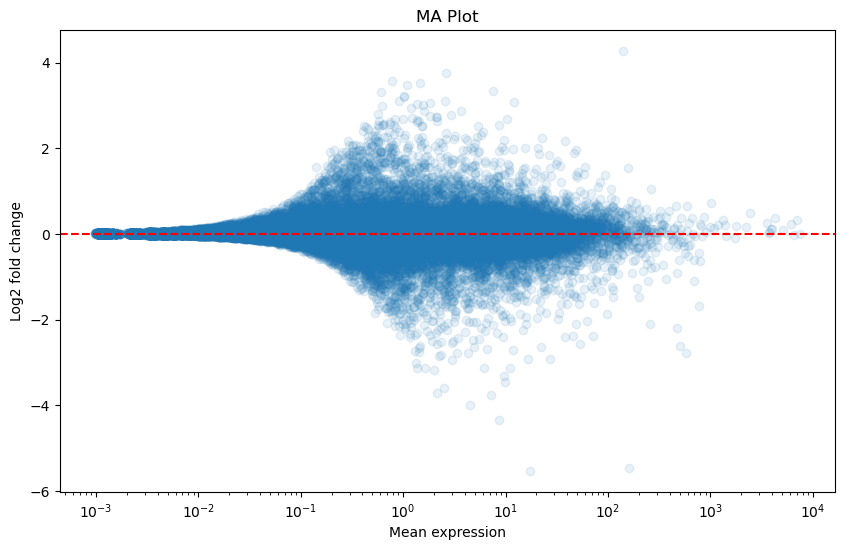

In [74]:

# Step 5: Visualize the results

# MA plot
plt.figure(figsize=(10, 6))
plt.scatter(results['baseMean'], results['log2FoldChange'], alpha=0.1)
plt.xscale('log')
plt.xlabel('Mean expression')
plt.ylabel('Log2 fold change')
plt.title('MA Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()


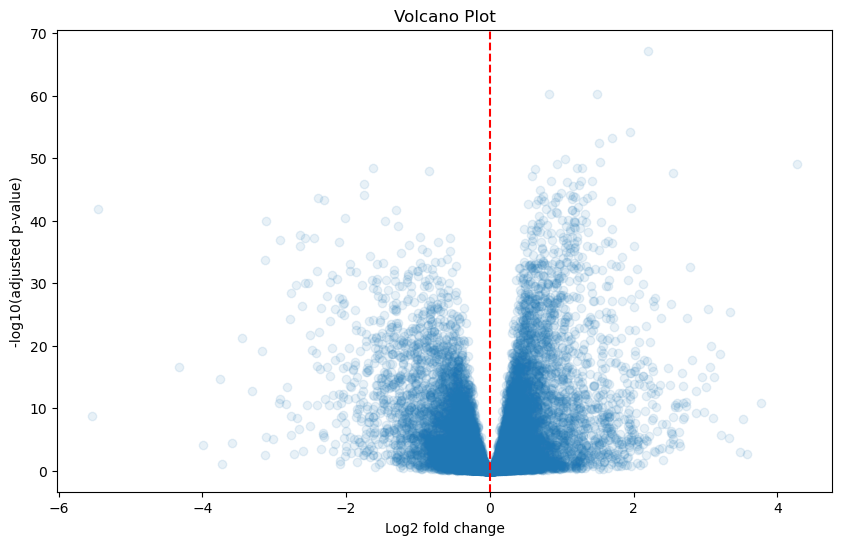

In [120]:

# Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(results['log2FoldChange'], -np.log10(results['padj']), alpha=0.1)
plt.xlabel('Log2 fold change')
plt.ylabel('-log10(adjusted p-value)')
plt.title('Volcano Plot')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()


### Running Deseq on Top genes from decouplR

In [84]:
#filter out sample columns 
genes_filt = rnaseq_df_filtered.loc[:, rnaseq_df_filtered.columns.str.startswith('E')]

#extract protein coding column names to protein_cod
protein_cod = []
for col in genes_filt.columns:
    #print(col.split())
    if col.split('|')[2] == 'protein_coding':
        protein_cod.append(col)

In [85]:
len(protein_cod)

19962

In [86]:
#filter to only include protein coding cols in df
genes_prot = genes_filt[protein_cod]

In [87]:
genes_filt_mean = genes_prot.mean(axis = 0)
top_400 = genes_filt_mean.nlargest(400).index

top_genes = genes_filt[top_400]


In [88]:
gene_list = top_genes.columns.tolist()
gene_split = [gene.split('|')[1] for gene in gene_list]

In [89]:
gene_split

['MT-CO3',
 'MT-CO2',
 'MT-CO1',
 'MT-ND4',
 'MT-ATP6',
 'MT-CYB',
 'MT-ND3',
 'MT-ND1',
 'MT-ND2',
 'TMSB10',
 'FTL',
 'MT-ND4L',
 'MT-ND6',
 'MT-ND5',
 'ACTG1',
 'RPS12',
 'ACTB',
 'MT-ATP8',
 'RPS18',
 'S100A11',
 'SCGB2A2',
 'RPS11',
 'RPL8',
 'KRT19',
 'COL1A1',
 'SCGB1D2',
 'PIP',
 'XBP1',
 'RPS27',
 'COL3A1',
 'TMSB4X',
 'HSP90AB1',
 'EEF2',
 'RPS6',
 'HLA-DRA',
 'RPS4X',
 'SPARC',
 'PSAP',
 'GAPDH',
 'CRABP2',
 'MGP',
 'EEF1A1',
 'HLA-B',
 'RPL7A',
 'IFI6',
 'COL1A2',
 'RPL13A',
 'TFF1',
 'HLA-C',
 'AZGP1',
 'RPS2',
 'RPL3',
 'B2M',
 'S100A6',
 'CD74',
 'RPL10A',
 'IFITM3',
 'RPLP1',
 'RPLP2',
 'CD24',
 'RPL19',
 'RPLP0',
 'HSPB1',
 'SLC39A6',
 'TAGLN2',
 'RPS8',
 'RPS21',
 'IGFBP4',
 'HSP90AA1',
 'HLA-DRB1',
 'BGN',
 'LGALS1',
 'HLA-A',
 'RPL7',
 'CALR',
 'PPDPF',
 'S100A9',
 'LAPTM4A',
 'RPL12',
 'CPB1',
 'FN1',
 'MAGED2',
 'RPS25',
 'RPL11',
 'HSPA8',
 'LUM',
 'SLC25A6',
 'APOD',
 'MARCKSL1',
 'RPL29',
 'IGFBP5',
 'ATP5F1B',
 'SFRP2',
 'MYL12B',
 'PEBP1',
 'RPL35',
 'LTF',
 

In [114]:
len(gene_list)

400

In [95]:
msigdb = dc.get_resource('MSigDB')
msigdb.drop_duplicates(inplace=True)

56.5kB [00:00, 82.1MB/s]
528MB [01:55, 4.78MB/s] 


In [104]:
ORA_df = dc.get_ora_df(
    df = gene_split,
    net = msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True,
)

Running ora on df with 400 targets for 33552 sources with 20000 background features.


In [112]:
ORA_df['-log 10 p-value'] = np.log10(ORA_df['p-value'])*-1
test_pval_filt = ORA_df[ORA_df['p-value'] < 0.05]
test_pval_filt = test_pval_filt.sort_values(by= test_pval_filt.index, ascending=True)
test_pval_filt.head()

AttributeError: 'Index' object has no attribute 'as_type'

In [106]:

# test_pval_filt = test_pval_filt.sort_values(by=['-log 10 p-value'])
top_10 = test_pval_filt.tail(10)
top_10.head()


,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log 10 p-value
22096,ZWANG_EGF_INTERVAL_DN,210,0.042857,2.586488e-02,9.332242e-02,2.281374,8.338124,LY6E;MT-CYB;PLAAT4;PPDPF;RHOB;RPL12;SLPI;TIMP3...,1.587290
22099,ZZZ3_TARGET_GENES,263,0.114068,1.404336e-14,8.399968e-13,6.166279,196.683490,EEF1A1;NOP10;PGK1;RPL10A;RPL11;RPL15;RPL24;RPL...,13.852529
22101,chr10p14,17,0.117647,4.451863e-02,1.427355e-01,7.163829,22.292742,ATP5F1C;GATA3,1.351458
22116,chr12q13,270,0.044444,8.462171e-03,3.876660e-02,2.346874,11.199635,ATP5F1B;CD63;DCD;HNRNPA1;KRT18;KRT7;KRT8;MUCL1...,2.072518
22157,chr1q21,230,0.060870,2.332712e-04,1.994052e-03,3.217846,26.911838,APH1A;C1orf43;ILF2;PSMB4;RPS27;S100A10;S100A11...,3.632139


In [ ]:
decoupler_results = test_pval_filt
decoupler_results.to_csv('data/decoupler_results.tsv', index=True, sep='\t')
top_10.to_csv('data/top_10_genes.tsv', index=True, sep='\t')